# HW 4: MLE/MAP

## MLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
df = pd.read_csv("data/poly_regression_small.csv")
X_train, y_train = df["x"], df["y"]

In [3]:
# Splitting data: train - test
def split_data(X, Y, train_size):
    N = len(X)
    N_train = int(train_size * N)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[train_idx]
    Y_train = Y[train_idx]

    X_test = X[test_idx]
    Y_test = Y[test_idx]

    return X_train, X_test, Y_train, Y_test

df = pd.read_csv("data/poly_regression_large.csv")
_, X_test, _, y_test = split_data(np.array(df["x"]), np.array(df["y"]), train_size=0.8)

In [4]:
def f(x, theta):  # Polynomial
    s = 0
    for i in range(len(theta)):
        s = s + theta[i] * x**i
    return s

def mse(theta, X, y):
    y_pred = f(X, theta)
    error = np.square(y_pred - y)
    return np.mean(error)

In [5]:
def mle_grad_f(theta, X, y):
    k = theta.shape[0]
    PhiX = np.vander(X, k, increasing=True)  # Nxk matrix
    return PhiX.T @ (PhiX @ theta - y)

def mle_f(theta, X, y):
    k = theta.shape[0]
    PhiX = np.vander(X, k, increasing=True)
    return 0.5 * np.linalg.norm(PhiX @ theta - y, 2)**2

In [6]:
# Theta MLE with gradient descent
def gradient_descent(f, grad_f, D, theta0, alpha, maxit=5000, tolf=1e-6, tolx=1e-6):
    k = 1  # Iterations counter
    X, y = D
    thetak = theta0 - alpha * grad_f(theta0, X, y)  # Iteration k point

    theta = [theta0, thetak]
    f_val = [f(theta0, X, y), f(thetak, X, y)]
    norm_grad_0 = np.linalg.norm(
        grad_f(theta0, X, y), 2
    )  # Norm of gradient of starting point
    grad_norm = [norm_grad_0, np.linalg.norm(grad_f(thetak, X, y))]

    while (
        np.linalg.norm(grad_f(thetak, X, y), 2) > tolf * norm_grad_0
        and np.linalg.norm(thetak - theta0, 2) > tolx
        and k < maxit
    ):
        k += 1
        theta0 = thetak  # Stores k-1 iteration point
        grad_f_thetak = grad_f(thetak, X, y)
        thetak = thetak - alpha * grad_f_thetak  # Descent

        # Store results
        theta.append(thetak)
        f_val.append(f(thetak, X, y))
        grad_norm.append(np.linalg.norm(grad_f_thetak, 2))

    return theta, k, f_val, grad_norm

def gd_mle(X_train, y_train, k, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    theta_history, _, _, _ = gradient_descent(mle_f, mle_grad_f, D=(X_train, y_train), theta0=np.zeros(k), alpha=alpha, maxit=maxit, tolf = tolf, tolx = tolx)
    return theta_history[-1]

In [7]:
# Theta MLE with stochastic gradient descent
def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0]  # We assume both X and Y has shape (N, )
    d = theta0.shape[0]  # While theta0 has shape (d, )
    idx = np.arange(0, N)  # This is required for the shuffling

    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs,))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs,))  # Save gradient norms at each epoch

    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]

            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)

    return theta_history, loss_history, grad_norm_history

def sgd_mle(X_train, y_train, k, alpha, n_epochs, batch_size = 5):
    theta_history, _, _ = SGD(mle_f, mle_grad_f, (X_train, y_train), theta0=np.zeros(k), alpha=alpha, n_epochs=n_epochs, batch_size=batch_size)
    return theta_history[-1]

In [8]:
# Theta MLE with NEM (Normal Equations method)
def nem_mle(X_train, y_train, k):
    PhiX = np.vander(X_train, k, increasing=True)
    L = np.linalg.cholesky(PhiX.T @ PhiX)
    z = np.linalg.solve(L, PhiX.T @ y_train)
    theta = np.linalg.solve(L.T, z)
    return theta

In [9]:
k = 2
gd_theta = gd_mle(X_train, y_train, k, alpha=0.01)
sgd_theta = sgd_mle(X_train, y_train, k, alpha=0.01, n_epochs=1000)
nem_theta = nem_mle(X_train, y_train, k)

print(f"Test set MSE with GD : {mse(gd_theta, X_test, y_test)}")
print(f"Test set MSE with SGD : {mse(sgd_theta, X_test, y_test)}")
print(f"Test set MSE with NEM : {mse(nem_theta, X_test, y_test)}")

Test set MSE with GD : 0.02719357761079628
Test set MSE with SGD : 0.027092307967188926
Test set MSE with NEM : 0.02719303335429555


For k=2, the three regression models had almost identical results, with errors on the test set around 0.027. This demonstrates that Stochastic Gradient Descent can achieve results comparable to both Gradient Descent and the Normal Equation Method, while requiring significantly less memory.

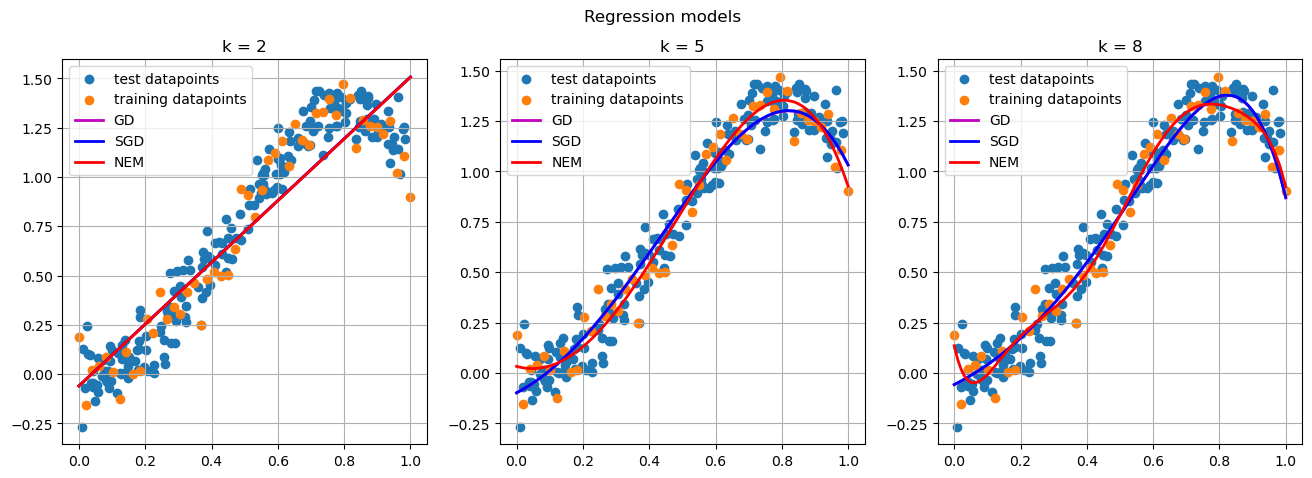

In [10]:
# Plotting regression models with datapoints
plt.figure(figsize=(16, 5))
plt.suptitle("Regression models")
x = np.concatenate([np.array(X_train), np.array(X_test)])
ordered_x = np.sort(x)

i = 1  # Subplot id
for k in (2, 5, 8):
    gd_theta = gd_mle(X_train, y_train, k, alpha=0.01, maxit=4000)
    sgd_theta = sgd_mle(X_train, y_train, k, alpha=0.01, n_epochs=4000)
    nem_theta = nem_mle(X_train, y_train, k)

    plt.subplot(1, 3, i)
    i += 1
    
    plt.scatter(X_test, y_test, label="test datapoints")
    plt.scatter(X_train, y_train, label = "training datapoints")

    plt.plot(ordered_x, f(ordered_x, gd_theta), label="GD", c="m", linewidth=2)
    plt.plot(ordered_x, f(ordered_x, sgd_theta), label="SGD", c="b", linewidth= 2)
    plt.plot(ordered_x, f(ordered_x, nem_theta), label="NEM", c="r", linewidth=2)
    plt.legend()
    plt.grid()
    plt.title(f"k = {k}")

plt.show()

For k=2, we observe that the linear regression models fail to approximate the non-linear data accurately, leading to underfitting.  
For k=8, the regression model lines exhibit overfitting; they are overly flexible and curve towards the training datapoints, capturing noise.  
For k=5, all three models fit the data well.  

This demonstrates that when the parameters for the descent methods are appropriately selected, the three methodologies yield equivalent results.

Note: The GD and SGD lines are nearly overlapping.

In [11]:
# Computing errors for increasing values of k
k_dims = np.arange(1, 10)
errors = {}
for k in k_dims:
    errors[k] = {}
    # GD errors
    gd_theta = gd_mle(X_train, y_train, k, alpha=0.01, maxit=10000)
    train_error = mse(gd_theta, X_train, y_train)
    test_error = mse(gd_theta, X_test, y_test)
    errors[k]["gd"] = {
        "train": train_error,
        "test": test_error
    }
    
    # SGD errors
    sgd_theta = sgd_mle(X_train, y_train, k, alpha=0.01 , n_epochs=10000, batch_size=5)
    train_error = mse(sgd_theta, X_train, y_train)
    test_error = mse(sgd_theta, X_test, y_test)
    errors[k]["sgd"] = {
        "train": train_error,
        "test": test_error
    }
    
    # NEM errors
    nem_theta = nem_mle(X_train, y_train, k)
    train_error = mse(nem_theta, X_train, y_train)
    test_error = mse(nem_theta, X_test, y_test)
    errors[k]["nem"] = {
        "train": train_error,
        "test": test_error
    }

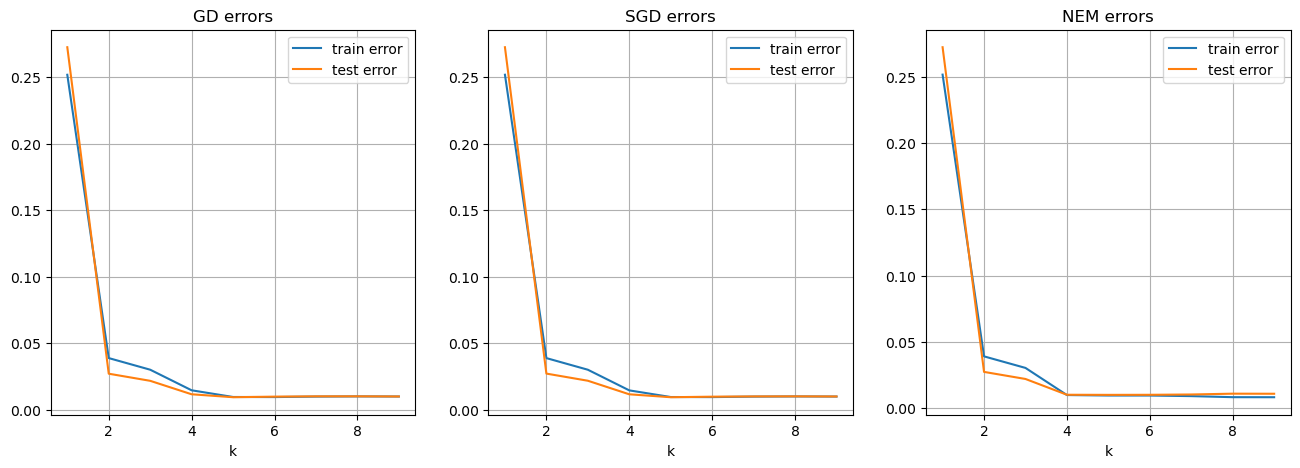

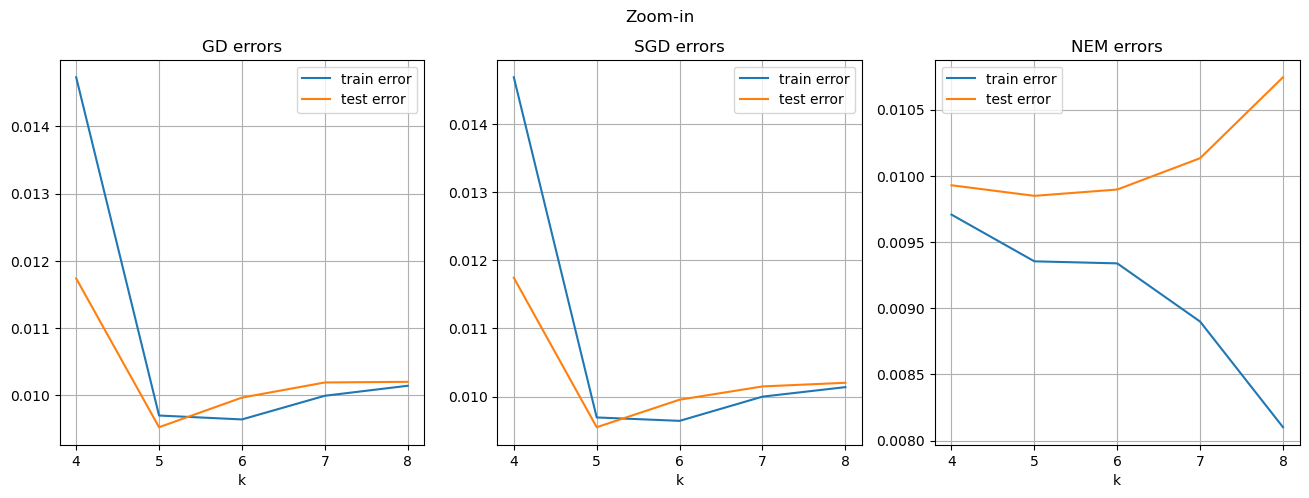

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(k_dims, [errors[k]["gd"]["train"] for k in k_dims], label="train error")
plt.plot(k_dims, [errors[k]["gd"]["test"] for k in k_dims], label="test error")
plt.grid()
plt.legend()
plt.title("GD errors")
plt.xlabel("k")

plt.subplot(1, 3, 2)
plt.plot(k_dims, [errors[k]["sgd"]["train"] for k in k_dims], label="train error")
plt.plot(k_dims, [errors[k]["sgd"]["test"] for k in k_dims], label="test error")
plt.grid()
plt.legend()
plt.title("SGD errors")
plt.xlabel("k")

plt.subplot(1, 3, 3)
plt.plot(k_dims, [errors[k]["nem"]["train"] for k in k_dims], label="train error")
plt.plot(k_dims, [errors[k]["nem"]["test"] for k in k_dims], label="test error")
plt.grid()
plt.legend()
plt.title("NEM errors")
plt.xlabel("k")

plt.show()

# Overfitting zoom-in
zoom_in_dims = np.arange(4, k_dims[-1])

plt.figure(figsize=(16, 5))
plt.suptitle("Zoom-in")
plt.subplot(1, 3, 1)
plt.plot(zoom_in_dims, [errors[k]["gd"]["train"] for k in zoom_in_dims], label="train error")
plt.plot(zoom_in_dims, [errors[k]["gd"]["test"] for k in zoom_in_dims], label="test error")
plt.grid()
plt.legend()
plt.title("GD errors")
plt.xlabel("k")

plt.subplot(1, 3, 2)
plt.plot(zoom_in_dims, [errors[k]["sgd"]["train"] for k in zoom_in_dims], label="train error")
plt.plot(zoom_in_dims, [errors[k]["sgd"]["test"] for k in zoom_in_dims], label="test error")
plt.grid()
plt.legend()
plt.title("SGD errors")
plt.xlabel("k")

plt.subplot(1, 3, 3)
plt.plot(zoom_in_dims, [errors[k]["nem"]["train"] for k in zoom_in_dims], label="train error")
plt.plot(zoom_in_dims, [errors[k]["nem"]["test"] for k in zoom_in_dims], label="test error")
plt.grid()
plt.legend()
plt.title("NEM errors")
plt.xlabel("k")

plt.show()

The train and test set errors are very close because the data was generated from the same polynomial function with added noise. For k<4, the errors are high due to underfitting. The lowest errors occur at k=5, which corresponds to the degree of the true underlying function. After k=5, the errors begin to increase slightly due to overfitting. As expected, all three methodologies produced equivalent results.

## MAP

In [13]:
l = 0.01  # Lambda
    
def map_f(theta,  X, y):
    k = theta.shape[0]
    PhiX = np.vander(X, k, increasing=True)  # Nxk matrix
    return 0.5 * np.linalg.norm(PhiX @ theta - y, 2)**2 + l / 2 * np.linalg.norm(theta, 2)**2

def map_grad_f(theta, X, y):
    k = theta.shape[0]
    PhiX = np.vander(X, k, increasing=True)  # Nxk matrix
    return theta @ (PhiX.T @ PhiX + l * np.eye(k)) - PhiX.T @ y

In [14]:
def gd_map(X_train, y_train, k, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    theta_history, _, _, _ = gradient_descent(map_f, map_grad_f, D=(X_train, y_train), theta0=np.zeros(k), alpha=alpha, maxit=maxit, tolf = tolf, tolx = tolx)
    return theta_history[-1]

def sgd_map(X_train, y_train, k, alpha, n_epochs, batch_size = 5):
    theta_history, _, _ = SGD(map_f, map_grad_f, (X_train, y_train), theta0=np.zeros(k), alpha=alpha, n_epochs=n_epochs, batch_size=batch_size)
    return theta_history[-1]

def nem_map(X_train, y_train, k, l):
    PhiX = np.vander(X_train, k, increasing=True)
    L = np.linalg.cholesky(PhiX.T @ PhiX + l * np.eye(k))
    z = np.linalg.solve(L, PhiX.T @ y_train)
    theta = np.linalg.solve(L.T, z)
    return theta

In [15]:
k = 2
gd_theta = gd_map(X_train, y_train, k, alpha=0.02)
sgd_theta = sgd_map(X_train, y_train, k, alpha=0.02, n_epochs=3000)
nem_theta = nem_map(X_train, y_train, k, l)

print(f"Test set MSE with GD : {mse(gd_theta, X_test, y_test)}")
print(f"Test set MSE with SGD : {mse(sgd_theta, X_test, y_test)}")
print(f"Test set MSE with NEM : {mse(nem_theta, X_test, y_test)}")

Test set MSE with GD : 0.027279534098432975
Test set MSE with SGD : 0.028501817576067685
Test set MSE with NEM : 0.027279273359789365


For the MAP formulation, the three techniques had identical results to the ones with the MLE formulation. The MSE are almost identical for all three methodologies, all three are slightly greater then 0.027.

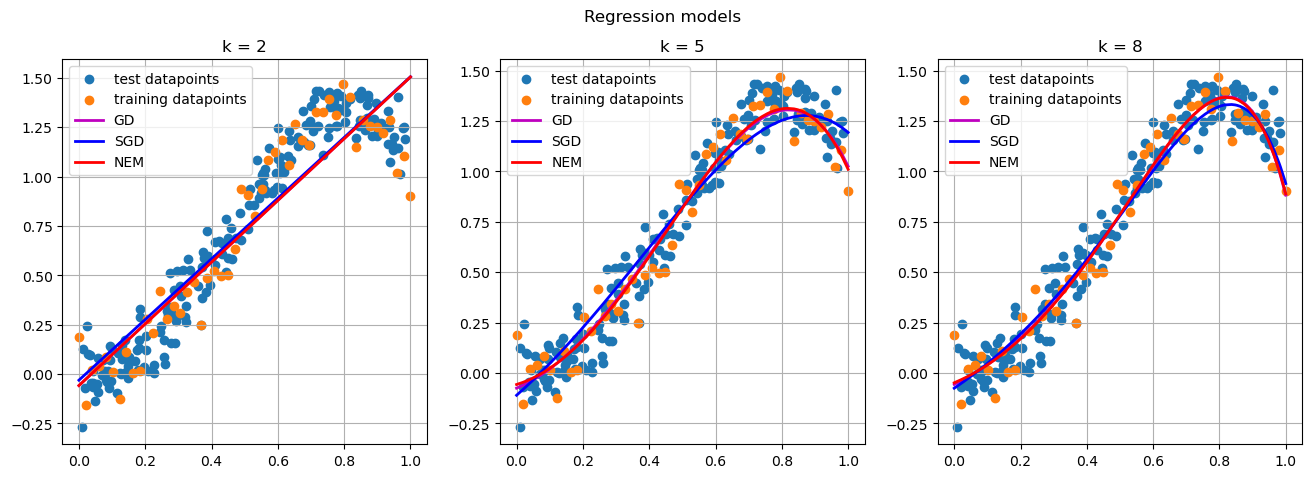

In [16]:
# Plotting regression models with datapoints
plt.figure(figsize=(16, 5))
plt.suptitle("Regression models")
x = np.concatenate([np.array(X_train), np.array(X_test)])
ordered_x = np.sort(x)

i = 1  # Subplot id
for k in (2, 5, 8):
    gd_theta = gd_map(X_train, y_train, k, alpha=0.02, maxit=4000)
    sgd_theta = sgd_map(X_train, y_train, k, alpha=0.02, n_epochs=4000)
    nem_theta = nem_map(X_train, y_train, k, l)

    plt.subplot(1, 3, i)
    i += 1
    
    plt.scatter(X_test, y_test, label="test datapoints")
    plt.scatter(X_train, y_train, label = "training datapoints")

    plt.plot(ordered_x, f(ordered_x, gd_theta), label="GD", c="m", linewidth=2)
    plt.plot(ordered_x, f(ordered_x, sgd_theta), label="SGD", c="b", linewidth= 2)
    plt.plot(ordered_x, f(ordered_x, nem_theta), label="NEM", c="r", linewidth=2)
    plt.legend()
    plt.grid()
    plt.title(f"k = {k}")

plt.show()

Similarly to the MLE formulation, the models underfit for k=2, fit well for k=5, and overfitted for k=8. The polynomial degree influences the quality of the result.

### k = 8

In [17]:
k = 8
lambdas = (0, 1e-5,1e-4 ,0.001, 0.01, 0.1, 1)

# SGD-GD parameters, used for both MLE and MAP
alpha = 0.021
n_epochs = 30_000
maxit = 30_000

map_thetas = {}
mle_thetas = {}

# MAP
for l in lambdas:
    # Redefining functions for each lambda, alternative to redefining GD and SGD with an additional parameter
    def map_f(theta,  X, y):
        k = theta.shape[0]
        PhiX = np.vander(X, k, increasing=True)  # Nxk matrix
        return 0.5 * np.linalg.norm(PhiX @ theta - y, 2)**2 + l / 2 * np.linalg.norm(theta, 2)**2

    def map_grad_f(theta, X, y):
        k = theta.shape[0]
        PhiX = np.vander(X, k, increasing=True)  # Nxk matrix
        return theta @ (PhiX.T @ PhiX + l * np.eye(k)) - PhiX.T @ y
    
    map_thetas[l] = {}
    
    gd_theta = gd_map(X_train, y_train, k, alpha=alpha, maxit=maxit)
    map_thetas[l]["gd"] = gd_theta
    sgd_theta = sgd_map(X_train, y_train, k, alpha=alpha, n_epochs=n_epochs)
    map_thetas[l]["sgd"] = sgd_theta
    nem_theta = nem_map(X_train, y_train, k, l)
    map_thetas[l]["nem"] = nem_theta

# MLE
gd_theta = gd_mle(X_train, y_train, k, alpha=alpha, maxit=maxit)
mle_thetas["gd"] = gd_theta
sgd_theta = sgd_mle(X_train, y_train, k, alpha=alpha, n_epochs=n_epochs)
mle_thetas["sgd"] = sgd_theta
nem_theta = nem_mle(X_train, y_train, k)
mle_thetas["nem"] = nem_theta

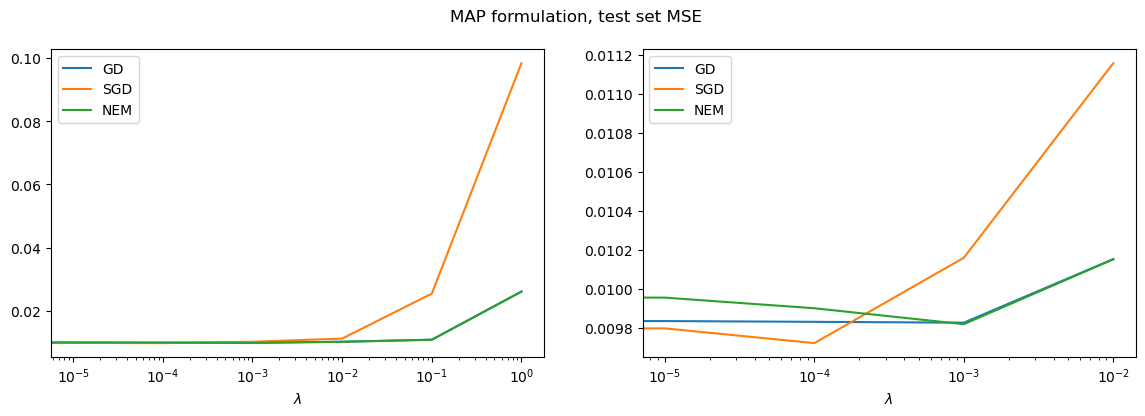

In [18]:
# Comparing MSE for different lambdas for the three methodologies
plt.figure(figsize=(14, 4))
plt.suptitle("MAP formulation, test set MSE")
plt.subplot(1, 2, 1)
plt.plot(lambdas, [mse(map_thetas[l]["gd"], X_test, y_test) for l in lambdas], label="GD")  # MAP GD errors
plt.plot(lambdas, [mse(map_thetas[l]["sgd"], X_test, y_test) for l in lambdas], label="SGD")  # MAP SGD errors
plt.plot(lambdas, [mse(map_thetas[l]["nem"], X_test, y_test) for l in lambdas], label="NEM")  # MAP GD errors
plt.legend()
plt.xscale("log")
plt.xlabel(r"$\lambda$")


plt.subplot(1, 2, 2)
plt.plot(lambdas[:-2], [mse(map_thetas[l]["gd"], X_test, y_test) for l in lambdas[:-2]], label="GD")  # MAP GD errors
plt.plot(lambdas[:-2], [mse(map_thetas[l]["sgd"], X_test, y_test) for l in lambdas[:-2]], label="SGD")  # MAP SGD errors
plt.plot(lambdas[:-2], [mse(map_thetas[l]["nem"], X_test, y_test) for l in lambdas[:-2]], label="NEM")  # MAP GD errors
plt.legend()
plt.xscale("log")
plt.xlabel(r"$\lambda$")

plt.show()

Different values for the regularization parameter produced different error results, showing that $\lambda$ affects the model quality. The smallest errors for GD and NEM were for $\lambda = 10^{-3}$, while for SGD $\lambda = 10^{-4}$. For small values of $\lambda$ (below the optimal value) the $\frac{\lambda}{2}||\theta||_2^2$ term becomes negligible, making the MAP formulation resemble the MLE formulation, causing overfitting. On the other hand, for larger $\lambda$, the $\frac{\lambda}{2}||\theta||_2^2$ becomes significant, penalizing larger values in $\theta$ and resulting in simpler model that underfits the data, leading to higher MSE.

SGD had worse results compared to the other two techniques for larger $\lambda$ values. The regularization parameter affects the approximated gradient: larger values of $\lambda$ make bigger changes in the approximated gradient, increasing the likelihood of differing significantly from the real gradient, thus, making SGD significantly slower to converge. 

In [19]:
# Comparing MPA and MLE
# lambda = 0.001
print("Test set MSE error with GD:")
print(f"MAP formulation: {mse(map_thetas[0.001]["gd"], X_test, y_test)}")
print(f"MLE formulation: {mse(mle_thetas["gd"], X_test, y_test)}")

print("Test set MSE error with SGD:")
print(f"MAP formulation: {mse(map_thetas[0.001]["sgd"], X_test, y_test)}")
print(f"MLE formulation: {mse(mle_thetas["sgd"], X_test, y_test)}")

print("Test set MSE error with NEM:")
print(f"MAP formulation: {mse(map_thetas[0.001]["nem"], X_test, y_test)}")
print(f"MLE formulation: {mse(mle_thetas["nem"], X_test, y_test)}")

Test set MSE error with GD:
MAP formulation: 0.009827482376059826
MLE formulation: 0.009836207009441386
Test set MSE error with SGD:
MAP formulation: 0.010160173891387746
MLE formulation: 0.009711801777756294
Test set MSE error with NEM:
MAP formulation: 0.00981974835859522
MLE formulation: 0.010744452124335599


The MSE was smaller for the MAP formulation when using Gradient Descent and the Normal Equation Method, demonstrating that the MAP formulation overfits less than the MLE formulation. However, for Stochastic Gradient Descent, the error was slightly greater for the MAP formulation because the algorithm did not converge to the optimal solution within the given number of epochs, preventing it from outperforming the corresponding MLE model.